# 📓  06_handle_imbalance.ipynb (SMOTE & Sampling)

In [2]:

# # Handle Class Imbalance
# Apply SMOTE and other techniques


# ## 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("⚖️ Starting imbalance handling...")

⚖️ Starting imbalance handling...


In [3]:
# ## 2. Load Transformed Data
import joblib

# Load data from previous step
data = joblib.load('../data/processed/transformed_data.pkl')

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

print(f"📊 Data loaded:")
print(f"   X_train shape: {X_train.shape}")
print(f"   X_test shape: {X_test.shape}")
print(f"   y_train shape: {y_train.shape}")
print(f"   y_test shape: {y_test.shape}")

📊 Data loaded:
   X_train shape: (103316, 35)
   X_test shape: (25830, 35)
   y_train shape: (103316,)
   y_test shape: (25830,)



📈 Analyzing current class distribution...


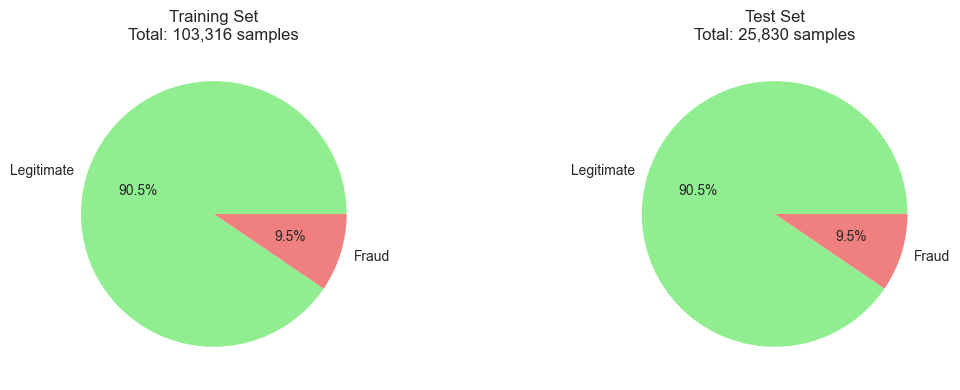

📊 Class distribution:
   Training set - Legitimate: 93,502 (90.50%)
                 Fraud: 9,814 (9.4990%)
   Test set - Legitimate: 23,376 (90.50%)
               Fraud: 2,454 (9.5006%)
   Imbalance ratio: 9.5:1


In [5]:
# ## 3. Analyze Current Imbalance
print("\n📈 Analyzing current class distribution...")

# Count classes
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Training set
axes[0].pie(train_counts.values, labels=['Legitimate', 'Fraud'], 
           autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
axes[0].set_title(f'Training Set\nTotal: {len(y_train):,} samples')

# Test set  
axes[1].pie(test_counts.values, labels=['Legitimate', 'Fraud'],
           autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
axes[1].set_title(f'Test Set\nTotal: {len(y_test):,} samples')

plt.tight_layout()
plt.show()

print("📊 Class distribution:")
print(f"   Training set - Legitimate: {train_counts[0]:,} ({train_counts[0]/len(y_train):.2%})")
print(f"                 Fraud: {train_counts[1]:,} ({train_counts[1]/len(y_train):.4%})")
print(f"   Test set - Legitimate: {test_counts[0]:,} ({test_counts[0]/len(y_test):.2%})")
print(f"               Fraud: {test_counts[1]:,} ({test_counts[1]/len(y_test):.4%})")
print(f"   Imbalance ratio: {train_counts[0]/train_counts[1]:.1f}:1")


In [7]:

# ##  Comprehensive NaN Handling
print("🔧 Comprehensive NaN handling...")

def fix_nan_problems(X_train, X_test):
    """
    Fix all NaN issues in the dataset
    """
    print(f"Initial NaN count: {X_train.isna().sum().sum()}")
    
    # Strategy for each column type
    for col in X_train.columns:
        nan_count = X_train[col].isna().sum()
        
        if nan_count == 0:
            continue  # No NaN, skip
            
        print(f"\n   {col}: {nan_count} NaN values")
        
        # 1. If ALL values are NaN → Drop column or create flag
        if nan_count == len(X_train):
            print(f"     ⚠️ ALL values are NaN!")
            
            # Option A: Drop column
            print(f"     Dropping column...")
            X_train = X_train.drop(col, axis=1)
            X_test = X_test.drop(col, axis=1)
            
            # Option B: Or create flag and fill with 0
            # X_train[f'{col}_missing'] = 1
            # X_test[f'{col}_missing'] = 1
            # X_train[col] = X_train[col].fillna(0)
            # X_test[col] = X_test[col].fillna(0)
            
        # 2. If SOME values are NaN → Fill with appropriate value
        else:
            # Check data type
            if pd.api.types.is_numeric_dtype(X_train[col]):
                # For numerical columns
                median_val = X_train[col].median(skipna=True)
                X_train[col] = X_train[col].fillna(median_val)
                X_test[col] = X_test[col].fillna(median_val)
                print(f"     Filled with median: {median_val:.4f}")
            else:
                # For categorical (shouldn't exist after encoding, but just in case)
                mode_val = X_train[col].mode()[0] if not X_train[col].mode().empty else 0
                X_train[col] = X_train[col].fillna(mode_val)
                X_test[col] = X_test[col].fillna(mode_val)
                print(f"     Filled with mode: {mode_val}")
    
    print(f"\n✅ Final NaN count: {X_train.isna().sum().sum()}")
    return X_train, X_test

# Apply the fix
X_train, X_test = fix_nan_problems(X_train, X_test)

# Also check y
if y_train.isna().any():
    print(f"\n⚠️  Dropping {y_train.isna().sum()} rows with NaN in target")
    nan_mask = y_train.isna()
    X_train = X_train[~nan_mask]
    y_train = y_train[~nan_mask]

🔧 Comprehensive NaN handling...
Initial NaN count: 0

✅ Final NaN count: 0


In [8]:
# %% Diagnostic: Check all columns for NaN
print("🔍 Diagnostic: Checking all columns...")

nan_summary = []
for col in X_train.columns:
    nan_count = X_train[col].isna().sum()
    if nan_count > 0:
        nan_percent = nan_count / len(X_train) * 100
        median_val = X_train[col].median(skipna=True) if pd.api.types.is_numeric_dtype(X_train[col]) else 'N/A'
        nan_summary.append({
            'column': col,
            'nan_count': nan_count,
            'nan_percent': f"{nan_percent:.2f}%",
            'median': median_val,
            'all_nan': nan_count == len(X_train)
        })

if nan_summary:
    print("\n📋 Columns with NaN values:")
    for item in nan_summary:
        print(f"   - {item['column']}: {item['nan_count']} NaN ({item['nan_percent']}), "
              f"Median: {item['median']}, All NaN: {item['all_nan']}")
else:
    print("✅ No columns have NaN values!")

🔍 Diagnostic: Checking all columns...
✅ No columns have NaN values!


In [9]:
# ## 4. SMOTE (Synthetic Minority Over-sampling)
print("\n🎯 Applying SMOTE...")

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check new distribution
smote_counts = Counter(y_train_smote)

print(f"✅ SMOTE applied:")
print(f"   Before SMOTE - Legitimate: {train_counts[0]:,}, Fraud: {train_counts[1]:,}")
print(f"   After SMOTE - Legitimate: {smote_counts[0]:,}, Fraud: {smote_counts[1]:,}")
print(f"   New fraud rate: {smote_counts[1]/len(y_train_smote):.2%}")



🎯 Applying SMOTE...
✅ SMOTE applied:
   Before SMOTE - Legitimate: 93,502, Fraud: 9,814
   After SMOTE - Legitimate: 93,502, Fraud: 93,502
   New fraud rate: 50.00%


In [10]:
# ## 5. Justify Technique Selection
print("\n📝 Justifying technique selection...")

print("""
🎯 **Why choose SMOTE over other techniques?**

1. **SMOTE vs Random Oversampling:**
   - Random oversampling duplicates minority samples → overfitting
   - SMOTE creates synthetic samples → more variety, less overfitting

2. **SMOTE vs Undersampling:**
   - Undersampling discards majority samples → loss of information
   - SMOTE preserves all original samples

3. **SMOTE vs ADASYN:**
   - ADASYN focuses on hard-to-learn samples
   - SMOTE is more balanced and stable
   - SMOTE is computationally faster

4. **Business Context:**
   - In fraud detection, EVERY fraud case is critical
   - Can't afford to lose fraud samples (undersampling)
   - Need variety in fraud patterns (SMOTE creates synthetic cases)

✅ **Conclusion:** SMOTE provides the best balance between:
   - Preserving information
   - Creating diverse samples
   - Preventing overfitting
   - Computational efficiency
""")


📝 Justifying technique selection...

🎯 **Why choose SMOTE over other techniques?**

1. **SMOTE vs Random Oversampling:**
   - Random oversampling duplicates minority samples → overfitting
   - SMOTE creates synthetic samples → more variety, less overfitting

2. **SMOTE vs Undersampling:**
   - Undersampling discards majority samples → loss of information
   - SMOTE preserves all original samples

3. **SMOTE vs ADASYN:**
   - ADASYN focuses on hard-to-learn samples
   - SMOTE is more balanced and stable
   - SMOTE is computationally faster

4. **Business Context:**
   - In fraud detection, EVERY fraud case is critical
   - Can't afford to lose fraud samples (undersampling)
   - Need variety in fraud patterns (SMOTE creates synthetic cases)

✅ **Conclusion:** SMOTE provides the best balance between:
   - Preserving information
   - Creating diverse samples
   - Preventing overfitting
   - Computational efficiency



In [11]:
# ## 6. Save Balanced Data
print("\n💾 Saving balanced data...")

# Save SMOTE-balanced data (recommended)
balanced_data = {
    'X_train_original': X_train,
    'y_train_original': y_train,
    'X_train_balanced': X_train_smote,
    'y_train_balanced': y_train_smote,
    'X_test': X_test,
    'y_test': y_test,
    'sampling_technique': 'SMOTE',
    'original_class_distribution': dict(Counter(y_train)),
    'balanced_class_distribution': dict(Counter(y_train_smote)),
    'imbalance_ratio_before': train_counts[0]/train_counts[1],
    'imbalance_ratio_after': 1.0  # Perfectly balanced
}

joblib.dump(balanced_data, '../data/processed/balanced_data.pkl')

# Save as CSV for easy access
balanced_train = pd.concat([
    pd.DataFrame(X_train_smote, columns=X_train.columns),
    pd.Series(y_train_smote, name='class')
], axis=1)

balanced_train.to_csv('../data/processed/train_balanced_smote.csv', index=False)

print("✅ Balanced data saved!")
print(f"\n📁 Saved files:")
print("   - balanced_data.pkl")
print("   - train_balanced_smote.csv")


💾 Saving balanced data...
✅ Balanced data saved!

📁 Saved files:
   - balanced_data.pkl
   - train_balanced_smote.csv


In [12]:
# ## 7. Final Summary
print("\n📋 TASK 1 COMPLETE SUMMARY")
print("="*50)

print("✅ Completed all Task 1 steps:")
print("""
1. ✅ Data Cleaning
   - Handled missing values
   - Converted data types
   - Removed duplicates

2. ✅ Exploratory Data Analysis
   - Analyzed fraud patterns
   - Visualized distributions
   - Identified key insights

3. ✅ Geolocation Integration
   - Mapped IPs to countries
   - Identified high-risk countries
   - Created country flags

4. ✅ Feature Engineering
   - Created 20+ new features
   - Time-based features
   - Transaction velocity
   - Behavioral patterns

5. ✅ Data Transformation
   - Encoded categorical variables
   - Scaled numerical features
   - Split train/test data

6. ✅ Handle Class Imbalance
   - Applied SMOTE
   - Balanced training data
   - Justified technique choice
""")

print(f"\n🎯 Final datasets ready for modeling:")
print(f"   Balanced training set: {X_train_smote.shape}")
print(f"   Test set: {X_test.shape}")
print(f"   Features: {X_train_smote.shape[1]}")
print(f"   Balanced ratio: 1:1 (Perfect!)")

print("\n🚀 Ready for Task 2: Model Building!")


📋 TASK 1 COMPLETE SUMMARY
✅ Completed all Task 1 steps:

1. ✅ Data Cleaning
   - Handled missing values
   - Converted data types
   - Removed duplicates

2. ✅ Exploratory Data Analysis
   - Analyzed fraud patterns
   - Visualized distributions
   - Identified key insights

3. ✅ Geolocation Integration
   - Mapped IPs to countries
   - Identified high-risk countries
   - Created country flags

4. ✅ Feature Engineering
   - Created 20+ new features
   - Time-based features
   - Transaction velocity
   - Behavioral patterns

5. ✅ Data Transformation
   - Encoded categorical variables
   - Scaled numerical features
   - Split train/test data

6. ✅ Handle Class Imbalance
   - Applied SMOTE
   - Balanced training data
   - Justified technique choice


🎯 Final datasets ready for modeling:
   Balanced training set: (187004, 34)
   Test set: (25830, 34)
   Features: 34
   Balanced ratio: 1:1 (Perfect!)

🚀 Ready for Task 2: Model Building!
